In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def get_points_min_curve(file):
    ident = open(file)
    x = []
    y = []
    z = []
    while True:
        line = ident.readline()

        if not line:
            break
            
        words = line.split(',', 3)
        print
        
        word_1 = words[0].split(':')
        word_2 = words[1].split(':')
        word_3 = words[2].split(':')

        x.append(float(word_1[2]))
        y.append(float(word_2[1]))
        z.append(float(word_3[1]))

    return x, y, z


In [28]:
def get_points_d(file):
    ident = open(file)
    x = []
    y = []
    z = []

    while True:
        line = ident.readline()
        if not line:
            break

        words = line.split(':')

        if len(words) == 3:
            x.append(float(words[2]))
        elif float(words[1]) == 0:
            z.append(float(words[1]))
        else:
            y.append(float(words[1]))

    return x, y, z

In [29]:
file_name = 'delauney_points.txt'
x, y, z = get_points_d(file_name)


In [30]:
file_name_2 = 'points.txt'
x_2, y_2, z_2 = get_points_min_curve(file_name_2)

In [31]:
def get_cones(file):
    ident = open(file)
    x = []
    y = []

    while True:
        line = ident.readline()
        if not line:
            break

        words = line.split(',')
        length = len(words)

        for i in range(length):
            if i%2 == 0:
                pos_x = words[i].find('(')
                #print(words[i][pos_x + 1 :])
                x.append(float(words[i][pos_x + 1 :]))
            else:
                pos_y = words[i].find(')')
                y.append(float(words[i][:pos_y]))

    return x, y

In [32]:
def get_combined_cones(file):
    ident = open(file)
    x = []
    y = []

    while True:
        line = ident.readline()
        if not line:
            break

        words = line.split(',', 2)
        
        pos_x = words[0].find('[')
        x.append(float(words[0][pos_x+1:].strip()))
        pos_y = words[1].find(']')
        y.append(float(words[1][:pos_y].strip()))

    return x, y

In [33]:
yellow_cone_file = 'yellow_cones.txt'
yellow_cone_x, yellow_cone_y = get_cones(yellow_cone_file)

blue_cone_file = 'blue_cones.txt'
blue_cone_x, blue_cone_y = get_cones(blue_cone_file)

In [34]:
combined_cone = 'combined_cones.txt'
combined_cone_x, combined_cone_y = get_combined_cones(combined_cone)

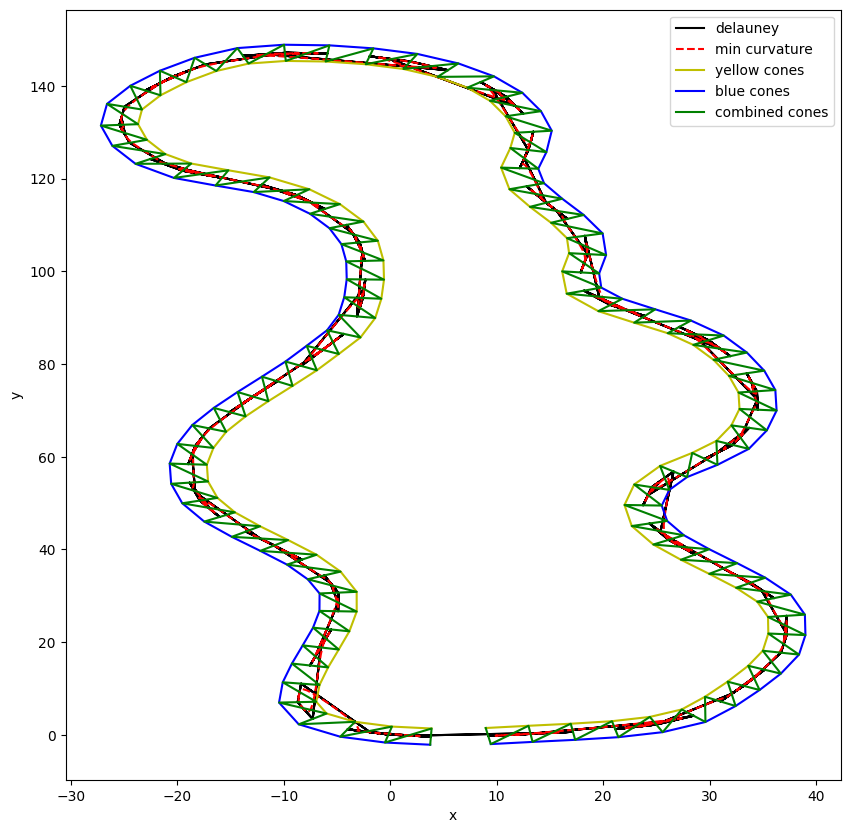

In [35]:
plt.figure(figsize=(10, 10))
plt.plot(x, y, '-k', label='delauney')
plt.plot(x_2, y_2, 'r--', label='min curvature')
plt.plot(yellow_cone_x, yellow_cone_y, '-y', label='yellow cones')
plt.plot(blue_cone_x, blue_cone_y, '-b', label='blue cones')
plt.plot(combined_cone_x, combined_cone_y, '-g', label='combined cones')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()


In [36]:
import math
track_width = np.sqrt((np.array(yellow_cone_x) - np.array(blue_cone_x))**2 + (np.array(yellow_cone_y) - np.array(blue_cone_y))**2)
min_track_width = np.min(track_width)

ref_path = np.array([x, y]).T

In [37]:
def filter_path(ref_path, state):
    min_dist = 1000000
    min_index = 0
    for i in range(len(ref_path)):
        dist = (ref_path[i][0] - state[0])**2 + (ref_path[i][1] - state[1])**2
        if dist < min_dist:
            min_dist = dist
            min_index = i

    return min_index

In [38]:
def find_cross_track_error(ref_path, state, min_track_width):
    # Find the nearest point on the path
    max_deviation = min_track_width/2
    min_dist = 1000000
    min_index = 0
    for i in range(len(ref_path)):
        dist = (ref_path[i][0] - state[0])**2 + (ref_path[i][1] - state[1])**2
        if dist < min_dist:
            min_dist = dist
            min_index = i

    # # Find the cross track error
    # if min_index == 0:
    #     min_index += 1
    # elif min_index == len(ref_path) - 1:
    #     min_index -= 1

    x1 = ref_path[min_index - 1][0]
    y1 = ref_path[min_index - 1][1]
    x2 = ref_path[min_index][0]
    y2 = ref_path[min_index][1]
    x3 = state[0]
    y3 = state[1]
    cross_track_error = (y2 - y1) * x3 - (x2 - x1) * y3 + x2 * y1 - y2 * x1
    cross_track_error /= math.sqrt((y2 - y1)**2 + (x2 - x1)**2)

    normalized_cross_track_error = cross_track_error / max_deviation

    return normalized_cross_track_error 

In [39]:
id = []
for i in range(len(yellow_cone_x)):
    id.append(filter_path(ref_path, np.array([yellow_cone_x[i], yellow_cone_y[i]])))

ref_path_filtered = ref_path[id]

In [40]:
cte_yellow = []
for i in range(len(yellow_cone_x)):
    cte = find_cross_track_error(ref_path_filtered, np.array([yellow_cone_x[i], yellow_cone_y[i]]), min_track_width)
    cte_yellow.append(cte)

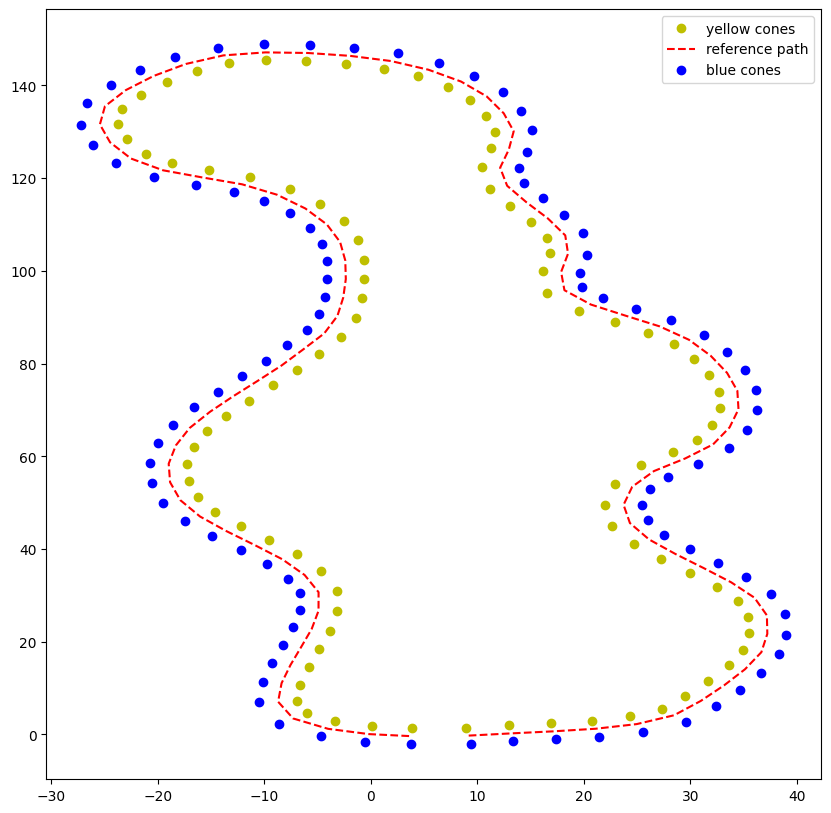

In [41]:
plt.figure(figsize=(10, 10))
plt.plot(yellow_cone_x, yellow_cone_y, 'oy', label='yellow cones')
plt.plot(ref_path_filtered[:,0], ref_path_filtered[:, 1], '--r', label='reference path')
plt.plot(blue_cone_x, blue_cone_y, 'ob', label='blue cones')
# plt.plot(ref_path[:11, 0], ref_path[:11, 1], '--og', label='reference path')
# plt.arrow(ref_path[0, 0], ref_path[0, 1], ref_path[1, 0] - ref_path[0, 0], ref_path[1, 1] - ref_path[0, 1], head_width=0.5, head_length=0.5, fc='k', ec='k')
# plt.arrow(ref_path[1, 0], ref_path[1, 1], ref_path[2, 0] - ref_path[1, 0], ref_path[2, 1] - ref_path[1, 1], head_width=0.5, head_length=0.5, fc='k', ec='b')
# plt.arrow(ref_path[2, 0], ref_path[2, 1], ref_path[3, 0] - ref_path[2, 0], ref_path[3, 1] - ref_path[2, 1], head_width=0.5, head_length=0.5, fc='k', ec='r')
plt.legend()

In [44]:
id_l = []
for i in range(len(cte_yellow)):
    if cte_yellow[i] > 0:
        id_l.append(i)

print(id_l)

[]


In [46]:
print(cte_yellow)

[-0.9935974493626978, -0.9999549278876353, -0.9999807570909964, -0.9994257838212168, -0.995220758195266, -0.9816934960974604, -0.9972451772494743, -0.9993540644807977, -0.9999591805093598, -0.9878654049187713, -0.9990943340421135, -0.9908653039191969, -0.9895489361532269, -0.9964277332301097, -0.9998195755195581, -0.9999414934810825, -0.9982530798483064, -0.988826934144044, -0.9825664227847988, -0.9910915535666752, -0.9765500792374026, -0.9999919256475714, -0.980853071546127, -0.9962313357557241, -0.9938547173563559, -0.9920096574333591, -0.9967679152250151, -0.9976541830424775, -0.9971930243484357, -0.9911228780511082, -0.999750175458767, -0.9977143697620565, -0.9574374922486759, -0.9778627146063635, -0.999052870677899, -0.9740140689747359, -0.9967820448952533, -1.0000044311010268, -0.9959547868497535, -0.9715314121299276, -0.9986957364690988, -0.9702853131904288, -0.9963330051334244, -0.9948876641809693, -0.9917197355907259, -0.994804742352951, -0.994491413865711, -0.9971383621997669